# Exercice 5 : Classification sur un ensemble de données donné

## Introduction

Dans cet exercice, on va effectuer une classification. Notre objectif est d'obtenir une précision moyenne supérieure à 0,85 sur l'ensemble de test.

## 1. Importation des libraries et chargement des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [2]:
X_train = np.load("C:\\Users\\abela\\Desktop\\Epita\\FTML\\Exo5\\X_test.npy")
y_train = np.load("C:\\Users\\abela\\Desktop\\Epita\\FTML\\Exo5\\y_test.npy")
X_test = np.load("C:\\Users\\abela\\Desktop\\Epita\\FTML\\Exo5\\X_train.npy")
y_test = np.load("C:\\Users\\abela\\Desktop\\Epita\\FTML\\Exo5\\y_train.npy")

## 2. Analyse des données
Avant de commencer la modélisation, examinons les données.

Forme de X_train : (500, 30)
Forme de X_test : (500, 30)
Distribution des classes dans y_train : (array([0, 1], dtype=int64), array([201, 299], dtype=int64))
Distribution des classes dans y_test : (array([0, 1], dtype=int64), array([241, 259], dtype=int64))


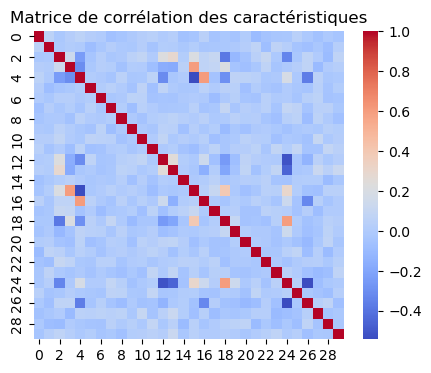

In [12]:
print(f"Forme de X_train : {X_train.shape}")
print(f"Forme de X_test : {X_test.shape}")
print(f"Distribution des classes dans y_train : {np.unique(y_train, return_counts=True)}")
print(f"Distribution des classes dans y_test : {np.unique(y_test, return_counts=True)}")

corr_matrix = pd.DataFrame(X_train).corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Matrice de corrélation des caractéristiques")
plt.show()

## 3. Prétraitement et sélection des caractéristiques
Nous allons utiliser un pipeline pour standardiser les données et sélectionner les meilleures caractéristiques.

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=20))
])

X_train_prepared = pipeline.fit_transform(X_train, y_train)
X_test_prepared = pipeline.transform(X_test)

selected_features = pipeline.named_steps['feature_selection'].get_support(indices=True)
print("Indices des caractéristiques sélectionnées:", selected_features)

Indices des caractéristiques sélectionnées: [ 0  2  4  6  8  9 10 11 12 13 15 16 18 20 21 24 25 26 27 29]


## 4. Fonction d'évaluation des modèles

In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {model_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return accuracy

## 5. Modélisation et optimisation

5.1 Random Forest

Random Forest (optimized) Test accuracy: 0.7840
Random Forest (optimized) Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       241
           1       0.76      0.85      0.80       259

    accuracy                           0.78       500
   macro avg       0.79      0.78      0.78       500
weighted avg       0.79      0.78      0.78       500



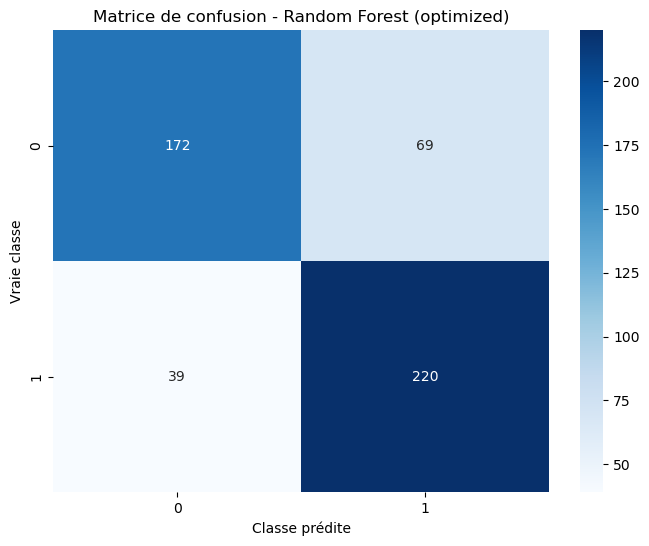

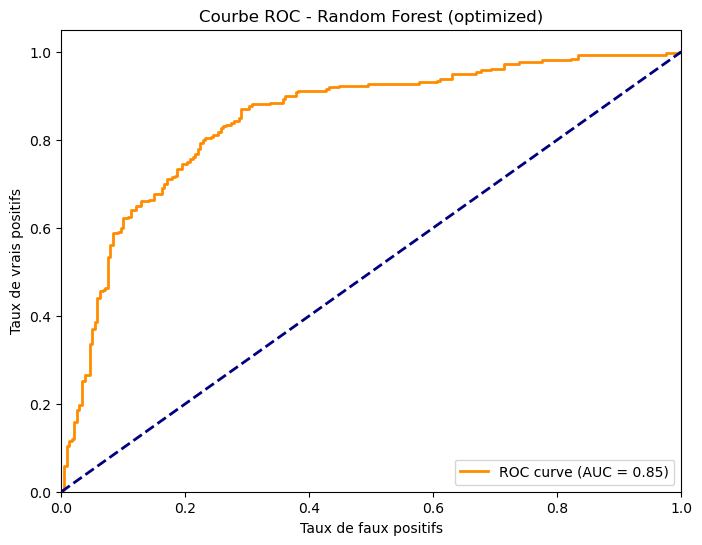

In [8]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_accuracy = evaluate_model(rf, X_train_prepared, X_test_prepared, y_train, y_test, "Random Forest (optimized)")

5.2 XGBoost

XGBoost (optimized) Test accuracy: 0.7480
XGBoost (optimized) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       241
           1       0.73      0.81      0.77       259

    accuracy                           0.75       500
   macro avg       0.75      0.75      0.75       500
weighted avg       0.75      0.75      0.75       500



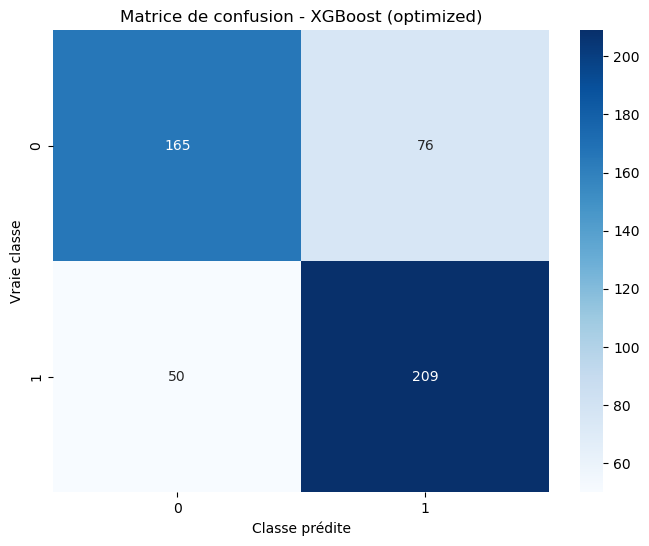

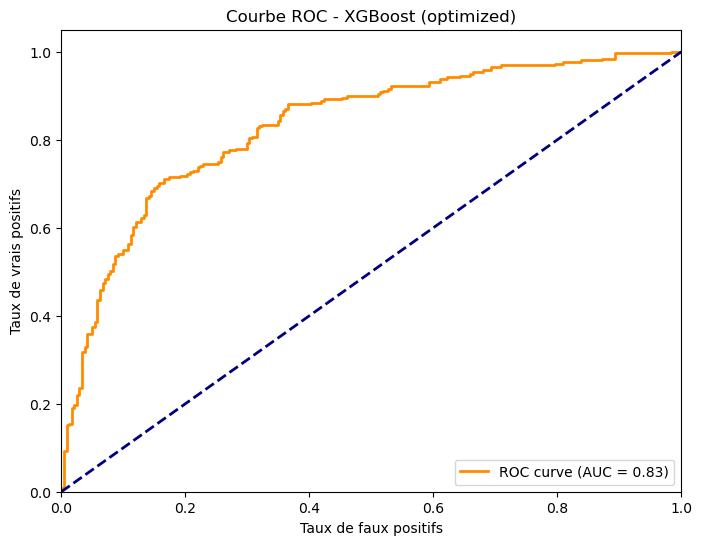

In [9]:
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb = GridSearchCV(XGBClassifier(random_state=42), xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_accuracy = evaluate_model(xgb, X_train_prepared, X_test_prepared, y_train, y_test, "XGBoost (optimized)")

6. Résultats

In [11]:
models = {
    "Random Forest (optimized)": rf_accuracy,
    "XGBoost (optimized)": xgb_accuracy
}

for name, accuracy in models.items():
    print(f"{name} accuracy: {accuracy:.4f}")

best_model = max(models, key=models.get)
best_accuracy = models[best_model]


Random Forest (optimized) accuracy: 0.7840
XGBoost (optimized) accuracy: 0.7480


On arrive pas à l'accuracy demandé.
On pourrait utiliser d'autres model pour voir si ils marchent mieux que xgboost et random forest